## Epoching Data and Producing Averaged Wave Data
We will also include a dataframe with densities split on brainwave type

In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import scipy.stats as stats

### Global Variables

In [2]:
sampling_rate = 512.0
epoch_length = 7.0

step = 100
maxamp = 750000
wavemax = int(maxamp/step)

### Helper Functions
#### Functions for Epoching Data

In [3]:
#
# Cleans a given raw openvibe dataframe
#
def clean_trial(trial):
    
    #drop unwanted columns
    trial = trial.drop(columns=['Event Duration'])
    trial = trial.drop(columns=['Event Date'])
    trial = trial.drop(columns=['Electrode'])
    
    #remove nans and key releases
    trial.loc[trial['Event Id'] == 33024,  'Event Id'] = 0
    trial.loc[trial['Event Id'].isnull(),  'Event Id'] = 0
    
    #shift df to start on start key press
    start_index = trial.index[trial['Event Id'] == 33025]
    trial = trial[(start_index[0]+1):].reset_index()
    trial = trial.drop(columns=['index'])
    
    #reset epoch to begin at 0/drop epoch column
    #trial = trial.drop(columns=['Epoch'])
    trial['Epoch']-=trial['Epoch'][0]
    
    #reset time to begin at 0
    trial['Time:512Hz']-=trial['Time:512Hz'][0]
    
    #set found waldo id 1
    trial.loc[trial['Event Id'] == 33027,  'Event Id'] = 1
    
    #rename columns as needed
    trial = trial.rename(columns={"Time:512Hz": "Time", "Event Id": "Event"})
    
    #cut end of data
    found_times = trial.loc[trial['Event'] == 1,'Time'].tolist()
    end_index = trial.index[trial['Time'] == found_times[len(found_times)-1]][0]
    trial = trial[0:end_index+1]
    
    
    return trial

In [4]:
#
# Reads and cleans the csv file at the given filepath
#
def processcsv(filename):
    raw = pd.read_csv(filename)
    clean = clean_trial(raw)
    return clean

In [5]:
#
# For/If we need to filter
#
def custom_filter(trial):
    print("Filter not implemented yet")

In [6]:
#
# Takes in the cleaned up data and returns an array.
# Each entry of the array has a pandas dataframe corresponding to a trial,
# Where a trial ends the moment the 'found' key was pressed. 
# At that time the next stage begins
#
def split_trials(trial):
    
    final_split = []
    found_times = trial.loc[trial['Event'] == 1,'Time'].tolist()
    
    start = 0;
    end = found_times[0]
    
    for i in range(0,len(found_times)):
        
        start_index = trial.index[trial['Time'] == start][0]
        end_index = trial.index[trial['Time'] == end][0]
        
        curr_trial = trial.loc[start_index+1:end_index+1].reset_index()     #changed this line
        curr_trial = curr_trial.drop(columns=['index'])
        curr_trial['Time']-=curr_trial['Time'][0]
        
        final_split.append(curr_trial.copy())
        
        start = end;
        if(i<len(found_times)-1):
            end = found_times[i+1]
        
    return final_split

In [7]:
#
# Takes in a trial and completes the 'Epoch' column, starting at the 'start_epoch' parameter
# This parameter is default at 0, so the trial will start at epoch 0 and so on.
# Every epoch is of length 'epoch_length', defined at the top of the notebook
# The epoch corresponding to the found stage has its 'Event' column set to 1 (facilitates extraction)
#
def single_epoch(trial, start_epoch):
    
    end_time = trial['Time'][len(trial)-1]
    start_time = trial['Time'][0]
    #print(end_time)
    #print(start_time)
    num_epochs = int((end_time-start_time)/epoch_length)
    
    #print(num_epochs)
    
    event_epoch = start_epoch + num_epochs -1
    last_epoch =  start_epoch + num_epochs -1
    trial.loc[trial['Time'] <= (end_time),'Epoch'] = last_epoch
    last_epoch-=1
    
        
    limit = end_time - epoch_length
    if limit >= epoch_length:
        while(limit >= 0):
            trial.loc[trial['Time'] < (limit),'Epoch'] = last_epoch
            last_epoch-=1
            limit -= epoch_length
        
        limit += epoch_length
    
    trial = trial[trial['Time'] > limit]
    trial.loc[trial['Epoch'] == event_epoch,'Event'] = 1
    trial = trial.reset_index()
    trial = trial.drop(columns=['index'])
    
    trial['Time']-=trial['Time'][0]
    
    return trial

In [8]:
#
# Takes in all trials and epochs them with the 'single_epoch' function
#
def epoch_trials(all_trials):
    for i in range(0,len(all_trials)):
        all_trials[i] = single_epoch(all_trials[i], 0)
    return all_trials

In [9]:
#
# Reduce dataframe to just brainwave cols
# Returns a dataframe with just the brainwave values out of a trial
#
def get_brainwaves(trial):
    return trial.drop(columns=['Time','Attention','Epoch', 'Meditation', 'Event'])

#### Functions for Averaging Brainwave Densities

In [10]:
def average_densities(raw_df):
    '''
    Generate average densities of amplitudes across brainwave types. Also stack densities of each brainwave into density_matrix.
    
    Params:
    raw_df(DataFrame): Raw brainwave values (amplitudes)
    max_amp(int): Max amplitude to calculate densities up to
    
    Returns:
    mean_vector(ndarray): 1x(maxamp/step) vector. Index represents given amplitude, value represents density of given amplitude.
    density_matrix(ndarray) : 8x(maxamp/step) matrix. 
                              density_matrix(i,j) == density of amplitude j within brainwave type i
    '''

    # matrix to contain all densities
    # let rows == wave type, columns == pdf generated density Y at X amplitude (for given wave)
    density_matrix = np.empty([8,int(wavemax)])

    # iterate across all wave types and stack each wave type density as rows in density_matrix
    # wave type density is a 75,000 value list. each value represents the density of waves at [index] frequency
    for i in range(0, raw_df.shape[1]):
        print("Calculating density for wave " + str(i+1) + "/8")
        # potential optimization: clear repeating values in original df
        density = stats.gaussian_kde(raw_df.iloc[0:,i], bw_method='scott')
        density_matrix[i] = list(density.pdf(range(0,maxamp,step)))     # potential optimization: increase step width

    # now find the total average densities for all wave types, 
    # column wise (end with 1x75000 vector) that reprents overall behavior
    mean_vector = np.mean(density_matrix, axis=0)
    
    return mean_vector, density_matrix

In [35]:
def plot_avg(mean_vector, x_max=17000, fig_x=14, fig_y=8):
    '''
    Plot mean density of each amplitude. Not trivial because average_densities compresses the original densities by a factor of
    step.
    
    Params:
    mean_vector(ndarray): 1x(maxamp/step) vector. Index represents given amplitude, value represents density of given amplitude.
    x_max(int): Max value to show on plot x-axis.
    fig_x(int): X dimension of figure generated
    fig_y(int): Y dimension of figure generated
    '''
    # must create accurate x-axis vector (stretch by factor of step)
    x_axis = list(range(0,wavemax))
    x_axis = [x * step for x in x_axis]

    #generate plot
    plt.figure(figsize=(fig_x,fig_y))
    plt.plot(x_axis, mean_vector)
    plt.ylabel('Density')
    plt.legend(['Mean density across brainwaves'])
    plt.xlim(0, x_max)

In [36]:
def densityframe(density_matrix):
    '''
    Build dataframe of densities from density_matrix with brainwave distinctions intact.
    
    Params:
    density_matrix(ndarray): 8x(maxamp/step) matrix to build from. 
                            density_matrix(i,j) == density of amplitude j within brainwave type i
                            
    Return:
    density_df(DataFrame): Dataframe with amplitude/step on rows, brainwave types on columns.
    '''
    density_df = pd.DataFrame(density_matrix, 
                              index=['Delta','Theta','Low Alpha','High Alpha','Low Beta','High Beta','Low Gamma','Mid Gamma'])
    density_df = density_df.transpose()
    density_df['True Amplitude'] = (density_df.index + 1) * step
    
    return density_df

### Test: Chase Data
This section might later be replaced with the full processing of all data.

In [13]:
# Read cece's trial, cleans unwanted columns, cuts data to begin on 'start' event and end on last 'found' event
chase_trial = processcsv('chase_trial.csv')

In [14]:
chase_trial.head()

,Time,Epoch,Attention,Meditation,Delta,Theta,Low Alpha,High Alpha,Low Beta,High Beta,Low Gamma,Mid Gamma,Event
0,0.000000,0,50.0,43.0,34890.0,18711.0,3612.0,4114.0,5400.0,4510.0,575.0,727.0,0.0
1,0.001953,0,50.0,43.0,34890.0,18711.0,3612.0,4114.0,5400.0,4510.0,575.0,727.0,0.0
2,0.003906,0,50.0,43.0,34890.0,18711.0,3612.0,4114.0,5400.0,4510.0,575.0,727.0,0.0
3,0.005859,0,50.0,43.0,34890.0,18711.0,3612.0,4114.0,5400.0,4510.0,575.0,727.0,0.0
4,0.007812,0,50.0,43.0,34890.0,18711.0,3612.0,4114.0,5400.0,4510.0,575.0,727.0,0.0


In [15]:
# Splits the full data into separate dataframes per waldo search trial
trials = split_trials(chase_trial)

# Epochs the split up trials into epochs of length 'epoch_length' defined on top of the document
# The epoch corresponding to the found stage has its 'Event' column set to 1
epoched_trials = epoch_trials(trials)

C:\Users\Me\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In this particular case `epoched_trials` is 3 entries long because Chase did 3 puzzles

In [16]:
epoched_trials[0].head()

,Time,Epoch,Attention,Meditation,Delta,Theta,Low Alpha,High Alpha,Low Beta,High Beta,Low Gamma,Mid Gamma,Event
0,0.000000,0,44.0,56.0,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0,0.0
1,0.001953,0,44.0,56.0,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0,0.0
2,0.003906,0,44.0,56.0,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0,0.0
3,0.005859,0,44.0,56.0,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0,0.0
4,0.007812,0,44.0,56.0,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0,0.0


In [42]:
# create list to store brainwave only dfs generated from epoched trials in SEARCH phase
search_list = [get_brainwaves(trial[trial['Event'] == 0.0]) for trial in epoched_trials]
search_list[0].head()

,Delta,Theta,Low Alpha,High Alpha,Low Beta,High Beta,Low Gamma,Mid Gamma
0,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0
1,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0
2,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0
3,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0
4,4445.0,7189.0,5178.0,8570.0,1687.0,1850.0,915.0,781.0


In [43]:
# create list to store brainwave only dfs generated from epoched trials in FIND phase
found_list = [get_brainwaves(trial[trial['Event'] == 1.0]) for trial in epoched_trials]
found_list[0].head()

,Delta,Theta,Low Alpha,High Alpha,Low Beta,High Beta,Low Gamma,Mid Gamma
14335,3918.0,7176.0,1897.0,2330.0,1005.0,4776.0,1995.0,1411.0
14336,3918.0,7176.0,1897.0,2330.0,1005.0,4776.0,1995.0,1411.0
14337,3918.0,7176.0,1897.0,2330.0,1005.0,4776.0,1995.0,1411.0
14338,3918.0,7176.0,1897.0,2330.0,1005.0,4776.0,1995.0,1411.0
14339,3918.0,7176.0,1897.0,2330.0,1005.0,4776.0,1995.0,1411.0


In [44]:
search_mean, search_density_mat = average_densities(search_list[0])
found_mean, found_density_mat = average_densities(found_list[0])

Calculating density for wave 0/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8
Calculating density for wave 0/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8


### TODO: this plotting part (`plot_avg`) needs some work so that they get on the same axes, have identifying titles/labels, have more customizability

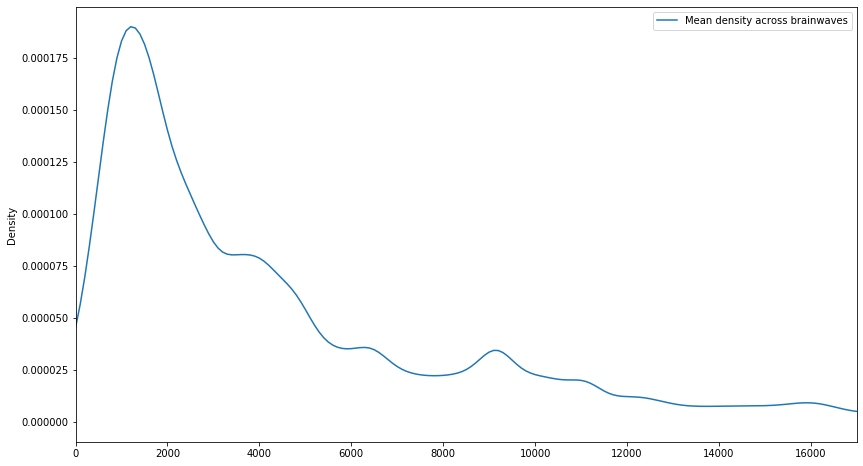

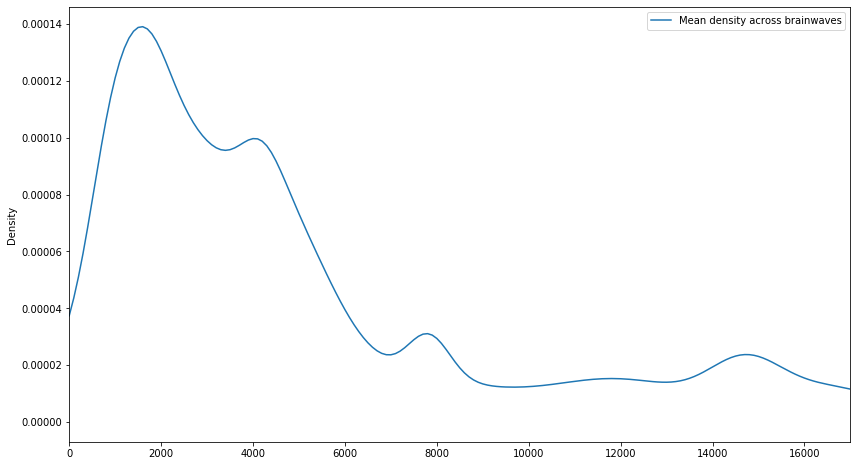

In [45]:
plot_avg(search_mean)
plot_avg(found_mean) 

In [46]:
search_density_df = densityframe(search_density_mat)
found_density_df = densityframe(found_density_mat)

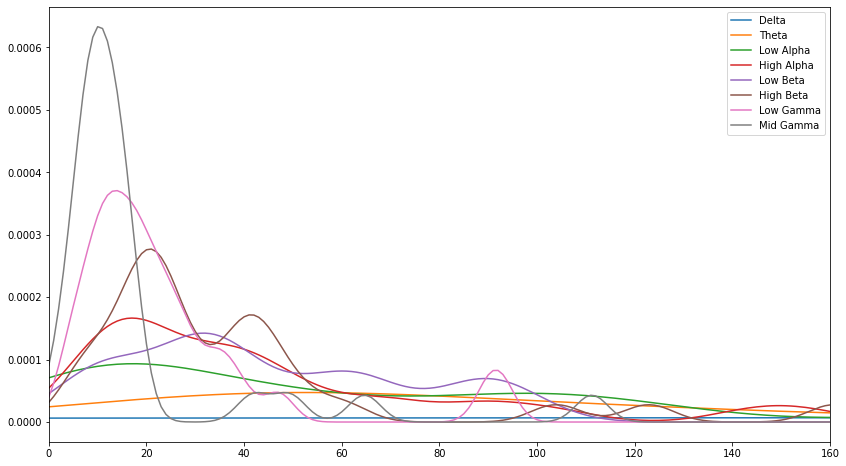

In [47]:
search_density_df.iloc[:,:-1].plot(figsize=(14,8))
plt.xlim(0,160)
plt.show()

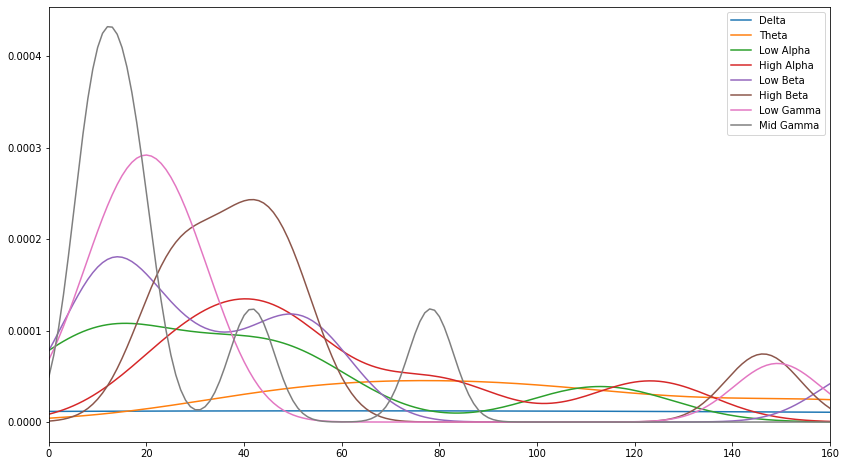

In [48]:
found_density_df.iloc[:,:-1].plot(figsize=(14,8))
plt.xlim(0,160)
plt.show()

### TODO: Right now all of the above runs on find/search from one trial from one person. Need to expand to all trials and then all people